In [102]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sktime.utils.plotting import plot_series
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.transformations.panel.compose import ColumnConcatenator
from sklearn.pipeline import Pipeline
from sktime.classification.kernel_based import RocketClassifier
from sklearn.calibration import CalibratedClassifierCV
from sktime.classification.interval_based import DrCIF

In [2]:
def cm_plot(y_test, y_pred):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title("Confusion Matrix")

    return plt.show()


In [3]:
X_train = np.load("/kaggle/input/neymark-tsc/train_x.npy")
y_train = np.load("/kaggle/input/neymark-tsc/train_y.npy")
X_test_real = np.load("/kaggle/input/neymark-tsc/test_x.npy")

In [4]:
X_train.shape

(14667, 187)

In [5]:
X_test_real.shape

(7225, 187)

In [6]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 26.6 MB/s eta 0:00:0000:0100:01


In [151]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

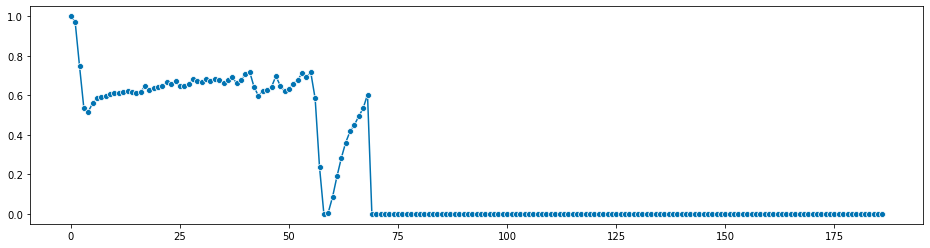

In [53]:
plot_series(pd.DataFrame(data=X_train[7]))

In [128]:
X_train_stand = (X_train - X_train.mean(axis = 0))/X_train.std(axis = 0)
X_test_stand = (X_test - X_test.mean(axis = 0))/X_test.std(axis = 0)

In [152]:
X_train_g = gaussian_filter(X_train, sigma=(.0,.1), mode='nearest')
X_test_g = gaussian_filter(X_test, sigma=(.0,.1), mode='nearest')

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

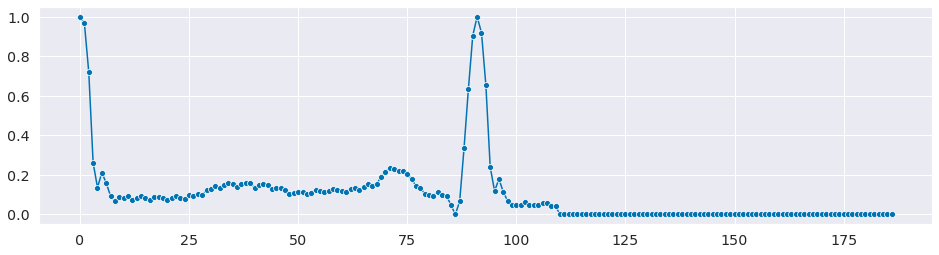

In [153]:
plot_series(pd.DataFrame(data=X_train_g[7]))

In [73]:
classifier = TimeSeriesForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
f1_score(y_test, y_pred, average="macro")

0.7994254278662218

In [75]:
steps = [("classify", TimeSeriesForestClassifier(n_estimators=100))]
clf = Pipeline(steps)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average="macro")

0.8325897332616586

In [76]:
rocket = RocketClassifier(num_kernels=1000)
rocket.fit(X_train, y_train)
y_pred = rocket.predict(X_test)
f1_score(y_test, y_pred, average="macro")

0.8702400091000584

In [79]:
rocket = RocketClassifier(num_kernels=1500)
rocket.fit(X_train, y_train)
y_pred = rocket.predict(X_test)
f1_score(y_test, y_pred, average="macro")

0.8818393703691294

In [107]:
rocket = RocketClassifier(num_kernels=1500)
rocket.fit(X_train_stand, y_train)
y_pred = rocket.predict(X_test_stand)
f1_score(y_test, y_pred, average="macro")

0.8933818331701877

In [119]:
rocket = RocketClassifier(num_kernels=1500)
rocket.fit(X_train_g, y_train)
y_pred = rocket.predict(X_test_g)
f1_score(y_test, y_pred, average="macro")

0.8847756781874049

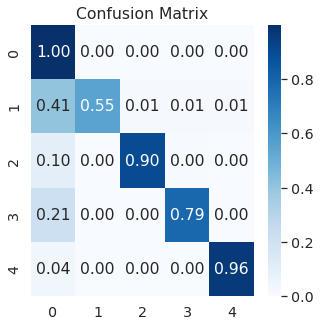

In [120]:
cm_plot(y_test, y_pred)

In [86]:
calibrated_drcif = CalibratedClassifierCV(
    base_estimator=DrCIF(n_estimators=10, n_intervals=5), cv=5
)

calibrated_drcif.fit(X_train, y_train)
y_pred = calibrated_drcif.predict(X_test)
f1_score(y_test, y_pred, average="macro")

0.889083767178475

In [108]:
calibrated_drcif = CalibratedClassifierCV(
    base_estimator=DrCIF(n_estimators=10, n_intervals=5), cv=5
)

calibrated_drcif.fit(X_train_stand, y_train)
y_pred = calibrated_drcif.predict(X_test_stand)
f1_score(y_test, y_pred, average="macro")

0.8734241603600308

In [142]:
y_pred = rocket.predict(X_test_real)

In [149]:
y_pred = calibrated_drcif.predict(X_test_real)

In [150]:
# y_pred_csv = pd.DataFrame(list(range(len(y_pred))), columns=["Id"])
y_pred_csv = pd.DataFrame()
y_pred_csv["ID"] = np.array(range(len(y_pred))).astype(int).astype(str)
y_pred_csv["Answer"] = np.array(y_pred).astype(int).astype(str)
y_pred_csv.to_csv("submission5.csv", index=False)
y_pred_csv

,ID,Answer
0,0,0
1,1,0
2,2,0
3,3,2
4,4,0
...,...,...
7220,7220,0
7221,7221,2
7222,7222,0
7223,7223,0
